In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
 
import os, shutil
import numpy as np
import pandas as pd
from types import SimpleNamespace
from matplotlib import pyplot as plt

2024-04-18 07:26:41.322694: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 07:26:41.322783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 07:26:41.467105: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
conf = SimpleNamespace(
    root_dir = "/kaggle/input/brain-tumor-mri-dataset/",
    work_dir = "/kaggle/working/data/",
    train_dir = "/kaggle/working/data/train/",
    test_dir = "/kaggle/working/data/test/",
    val_dir = "/kaggle/working/data/val/",
)

train_conf = SimpleNamespace(
    img_shape = (256, 256),
    batch_size = 32,
    epochs = 1
)

Total files: 5712


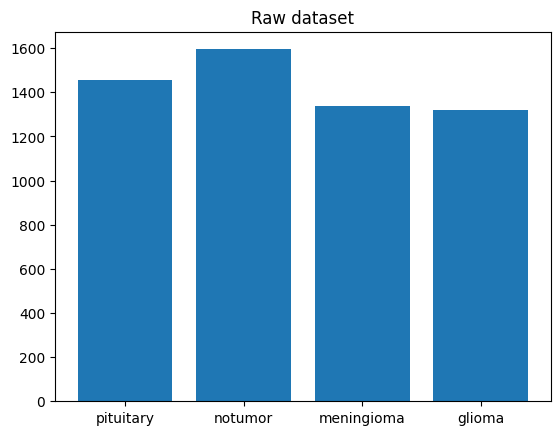

In [3]:
# EDA

def plot_catg_count(path, name=""):
    fc = 0
    cl_name = []
    cl_count = []
    for d in os.listdir(path):
        #print(f"{d} -- {len(os.listdir(train_path + d))}")
        cl_name.append(d)
        cl_count.append(len(os.listdir(path + d)))
        fc += len(os.listdir(path + d))

    print(f"Total files: {fc}")
    plt.bar(cl_name, cl_count)
    plt.title(name)
    

plot_catg_count(conf.root_dir + "Training/", name="Raw dataset")

In [4]:
# Make train, val and test set

def make_work_dir():
    os.makedirs(conf.work_dir, exist_ok=True)    
    os.makedirs(conf.train_dir, exist_ok=True)
    os.makedirs(conf.test_dir, exist_ok=True)
    os.makedirs(conf.val_dir, exist_ok=True)


def make_split(split_size=[0.7, 0.2, 0.1]):
    make_work_dir()
    
    raw_train_path = conf.root_dir + "Training/" 
    for d in os.listdir(raw_train_path):
        sub_dir = f"{raw_train_path}{d}/"
        files = os.listdir(sub_dir)
        file_count = len(files)
        
        for idx, fname in enumerate(files):
            if idx < int(file_count * split_size[0]):
                os.makedirs(f"{conf.train_dir}{d}/", exist_ok=True)
                f_new_path = f"{conf.train_dir}{d}/{fname}"
            elif idx < int(file_count * (split_size[0] + split_size[1])):
                os.makedirs(f"{conf.val_dir}{d}/", exist_ok=True)
                f_new_path = f"{conf.val_dir}{d}/{fname}"
            else:
                os.makedirs(f"{conf.test_dir}{d}/", exist_ok=True)
                f_new_path = f"{conf.test_dir}{d}/{fname}"
                
            f_curr_path = f"{sub_dir}{fname}"
            shutil.copyfile(f_curr_path, f_new_path)

In [5]:
make_split()

In [6]:
train_set = image_dataset_from_directory(
    conf.train_dir,
    batch_size=train_conf.batch_size,
    image_size=train_conf.img_shape,
    shuffle=True,
)

val_set = image_dataset_from_directory(
    conf.val_dir,
    batch_size=train_conf.batch_size,
    image_size=train_conf.img_shape,
    shuffle=True,
)

test_set = image_dataset_from_directory(
    conf.test_dir,
    batch_size=train_conf.batch_size,
    image_size=train_conf.img_shape,
    shuffle=True,
)

Found 3996 files belonging to 4 classes.
Found 1143 files belonging to 4 classes.
Found 573 files belonging to 4 classes.


Total files: 3996
Total files: 1143
Total files: 573


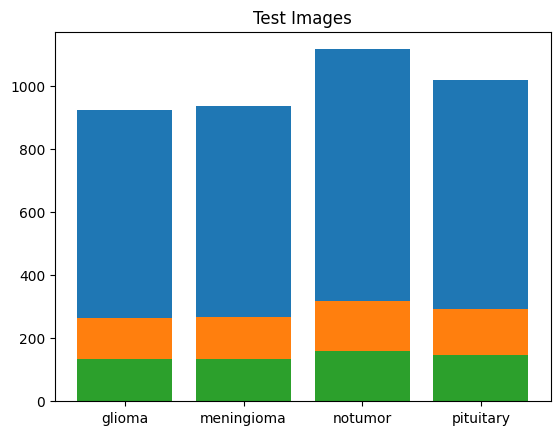

In [7]:
plot_catg_count(conf.train_dir, "Training Images")
plot_catg_count(conf.val_dir, "Validation Images")
plot_catg_count(conf.test_dir, "Test Images")

# **Transfer learning on Inception V3**

In [8]:
model_inp_shape = train_conf.img_shape + (3,)

base_model = tf.keras.applications.InceptionV3(input_shape=model_inp_shape,include_top=False,weights='imagenet')
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
global_average_layer = layers.GlobalAveragePooling2D()
flatten_layer = layers.Flatten()
dense_layer1 = layers.Dense(256, activation='relu')
dense_layer2 = layers.Dense(128, activation='relu')
dense_layer3 = layers.Dense(64, activation='relu')
prediction_layer = layers.Dense(4, activation='softmax')
preprocess_input = keras.applications.inception_v3.preprocess_input
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomFlip('vertical'),
    layers.RandomRotation(0.2),
])


inputs = tf.keras.Input(shape=(model_inp_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = flatten_layer(x)
x = dense_layer1(x)
x = dense_layer2(x)
x = dense_layer3(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_6 (TrueDivide)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_6 (Subtract)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,718,820 (155.33 MB)

 Trainable params: 18,916,036 (72.16 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [25]:
base_learning_rate = 0.0001
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = keras.callbacks.ModelCheckpoint(
    "brain_mri_4_catg.keras",
    monitor='val_acc',
    save_best_only=True,
)
callbacks = [callbacks]

# To faster training and using this for gradcam showing, train_set is currently set to test_set
history = model.fit(test_set, epochs=train_conf.epochs, validation_data=val_set, callbacks=callbacks)

16/18 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.8125 - loss: 0.4851

# **GradCAM**

In [ ]:
def grad_cam(model, image, class_index):
    last_conv_layer = model.get_layer(name='flatten_layer').input
    get_activations = tf.keras.Model(inputs=model.inputs, outputs=last_conv_layer)
    grads = None
    
    def gradient_hook(grad, var):
        nonlocal grads
        grads = grad

    last_conv_layer.register_gradient_hook(gradient_hook)

    predictions = model(image)
    class_output = predictions[:, class_index]

    with tf.GradientTape() as tape:
        tape.watch(class_output)
        activations = get_activations(image)
    grads = tape.gradient(class_output, last_conv_layer)

    pooled_grads = tf.reduce_mean(grads, axis=[1, 2])
    heatmap = tf.nn.conv2d_transpose(pooled_grads, get_activations(image).shape[1:4], strides=[1, 1, 1, 1], padding='SAME')

    heatmap = tf.math.relu(heatmap) / tf.math.reduce_max(tf.math.relu(heatmap))

    return heatmap[..., tf.newaxis]
